# Recurrent Neural Networks - N-Step Prediction
We turn to the n-step prediction of numerical values, or the forecasting of time series for a given time horizon.
The data for this notebook is the known zick-zack pattern, however this time the model is expected to complete the pattern of the sequence for a fixed amount of future time steps called the 'horizon'. Lets see some examples!

In [12]:
from data_generation import generate_longterm_data
import torch
import torch.nn as nn
import numpy as np
from typing import List, Callable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pipeline import train, plot_losses, TrainingStats, evaluate, AfterEpochCallbackParams
from dataclasses import dataclass
from models import Base_RNN, LSTM_RNN, GRU_RNN

RANDOM_SEED = 42

# Generate Data
NUM_SEQ = 1000
HORIZON=20
data_set, labels = generate_longterm_data(NUM_SEQ, variable_steps=False, noise=True, horizon=HORIZON)

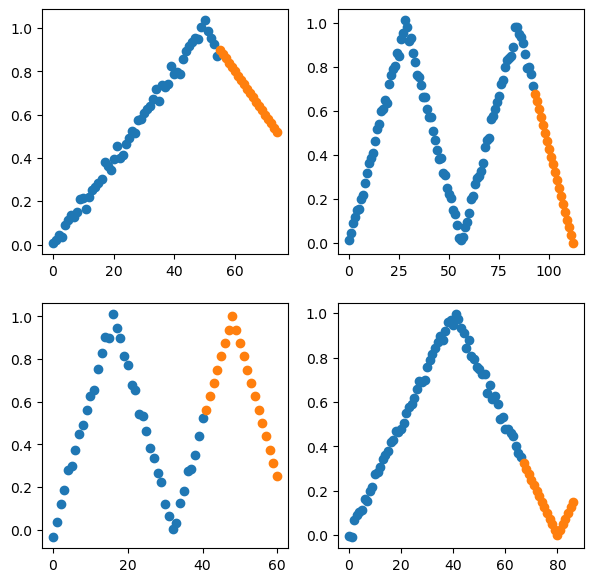

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7, 7))
for i, (data, label) in enumerate(zip(data_set[:4], labels[:4])):
    row_idx = i % 2
    col_idx = int(i / 2)
    axs[col_idx][row_idx].plot(data, "o")
    axs[col_idx][row_idx].plot(range(len(data), len(data)+len(label)), label, "o")

As you can see, the data again resembles the known pattern. The input data (in blue) also contains noise again, the label points (in orange) contain the true points of the pattern, without noise. 

---

## Data Exploration

In [14]:
# TODO (exploration):
# - stats (mean, median, std, min, max)
# - sequence lengths
# - label lengths
# - 

print(f"Anzahl Sequencen: {len(data_set)}")
print(f"Anzahl Labels: {len(labels)}")

sequence_lengths = {len(x) for x in data_set}
label_lengths = {len(x) for x in labels}

print(f"Sequenz Längen sind im Bereich von {min(sequence_lengths)} bis {max(sequence_lengths)}")
print(f"Die labels sind {label_lengths} Einträge lang")

Anzahl Sequencen: 1000
Anzahl Labels: 1000
Sequenz Längen sind im Bereich von 12 bis 100
Die labels sind {20} Einträge lang


In [15]:
print(f"Durchnitt Sequence Values: {np.mean([np.mean(x) for x in data_set]):.2f}")
print(f"Durchnitt Label Values: {np.mean([np.mean(x) for x in labels]):.2f}")

print(f"Durchnittliche Std der Sequence Values: {np.mean([np.std(x) for x in data_set]):.2f}")
print(f"Durchnittliche Std der Label Values: {np.mean([np.std(x) for x in labels]):.2f}")

print(f"Maximum der Sequence Values: {np.max([np.max(x) for x in data_set]):.2f}")
print(f"Maximum der Label Values: {np.max([np.max(x) for x in labels]):.2f}")

print(f"Minimum der Sequence Values: {np.min([np.min(x) for x in data_set]):.2f}")
print(f"Minimum der Label Values: {np.min([np.min(x) for x in labels]):.2f}")

Durchnitt Sequence Values: 0.47
Durchnitt Label Values: 0.53
Durchnittliche Std der Sequence Values: 0.27
Durchnittliche Std der Label Values: 0.18
Maximum der Sequence Values: 1.06
Maximum der Label Values: 1.00
Minimum der Sequence Values: -0.08
Minimum der Label Values: 0.00


Wir haben 1000 Sequencen, mit jeweils unterschiedlicher Länge. Darauf folgen immer 20 labels. Die Label Werte sind im Bereich 0 bis 1. Die Sequenzen auch großteils, es kann jedoch vereinzelnt Werte geben, die leicht größer als 1 und leicht kleiner als 0 sind.

Wie in den Plots ersichtlich ist, sind die lables die Fortsetzung der Sequence, die es nun gilt mit einem RNN vorherzusagen.

## Dumb Baselines

Hier sind ein paar sehr einfache (und dumme) Modelle, die unser RNN schlagen sollte:

1. Ein Modell, das immer den Mittelwert unserer Zielwerte vorhersagt.
2. Ein Modell, das immer den Median unserer Zielwerte vorhersagt.
3. Ein Modell, das immer 0,5 vorhersagt.

In [16]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as sklearn_mse, mean_absolute_error as sklearn_mae

mean_model = DummyRegressor(strategy="mean")
median_model = DummyRegressor(strategy="median")
point_five_model = DummyRegressor(strategy="constant", constant=0.5) # since the points are all between 0 and 1, using 0.5 as a baseline seems like a good idea

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, random_state=RANDOM_SEED)
dummy_models = [mean_model, median_model, point_five_model]

for model in dummy_models:
    print(model.__class__.__name__)
    mean_model.fit(X_train, y_train)
    predictions = mean_model.predict(X_test)
    print("MSE Loss: ", sklearn_mse(y_test, predictions))
    print("MAE Loss: ", sklearn_mae(y_test, predictions))

DummyRegressor
MSE Loss:  0.08306983297657147
MAE Loss:  0.24871845205654886
DummyRegressor
MSE Loss:  0.08306983297657147
MAE Loss:  0.24871845205654886
DummyRegressor
MSE Loss:  0.08306983297657147
MAE Loss:  0.24871845205654886


Wir können sehen, dass alle  Modelle nahezu identisch abschneiden (weil der Mittelwert, der Median und 0.5 alle sehr ähnlich sind).

Wir werden beide Errors ($MAE\approx0.25$ and $MSE\approx0.08$) für den späteren Vergleich mit dem RNN speichern.

In [18]:
# we will use the latest prediction (point_five_model) to initialize the baseline loss values.
BASELINE_MSE_LOSS =  sklearn_mse(y_test, predictions)
BASELINE_MAE_LOSS =  sklearn_mae(y_test, predictions)

## Training Pipeline

Die Training Pipeline besteht im wesentlichen aus 2 Methoden:
1. Train 
2. Evaluate

Siehe `pipeline.py` für Implementation.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, random_state=RANDOM_SEED)

In [20]:
import os

LOG_FILE_PATH = "./logs/history"
MODEL_DESCRIPTION = ""

def write_stats_callback(params: AfterEpochCallbackParams):
    model_name = params.model.__class__.__name__
    filepath = f"{LOG_FILE_PATH}/{model_name}-{MODEL_DESCRIPTION}"
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    with open(f"{filepath}/training-stats-1.csv", "a+") as f:
        header, content = params.as_csv_string()
        if params.epoch == 1:
            # write model params
            # for param_tensor in params.model.state_dict():
            #     f.write(f"{param_tensor}, '\t', {params.model.state_dict()[param_tensor].size()}")
            f.write(header + "\n")
        f.write(content  + "\n")


def save_best_model_callback(params: AfterEpochCallbackParams):
    """Saves a model if the validation loss is at a minimum."""
    min_val_loss = np.min(params.val_loss_history)
    model_name = params.model.__class__.__name__
    if params.current_val_loss <= min_val_loss:
        filepath = f"{LOG_FILE_PATH}/{model_name}-{MODEL_DESCRIPTION}/best-params"
        if not os.path.exists(filepath):
            os.makedirs(filepath)
        torch.save(params.model, f"{filepath}/params_epoch{params.epoch}.pt")

## Model Capacity

Siehe `models.py` für Implementationsdetails.

Bevor wir das Modell auf die ganzen Daten loschicken, wollen wir auf wenige Daten testen, ob unser Modell das Problem überhaupt schaffen kann.

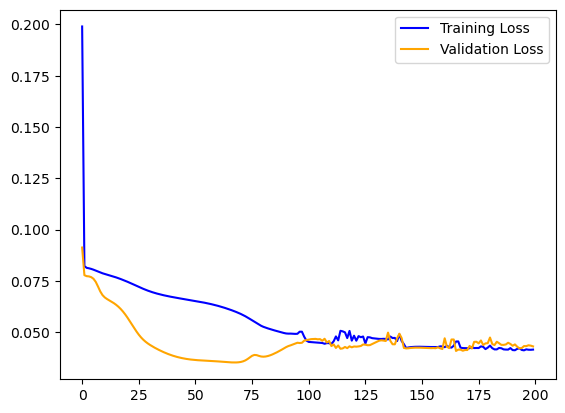

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, train_size=0.2, random_state=RANDOM_SEED)

model = Base_RNN(1,10,1) # Base_RNN model with 1 hidden state of size 10. Input and output size is 1
mse_loss = nn.MSELoss()
adam = torch.optim.Adam(model.parameters(), lr=3e-4)

train_result = train(model, 200, X_train, y_train, mse_loss, adam, post_epoch_callbacks=[write_stats_callback])

Wir sehen, in der Grafik, dass selbst bei 200 Datensätzen der Loss bereits kleiner ist als unsere Dumb baselines, aber wie sieht das grafisch aus?

MSE Loss:  0.045797825


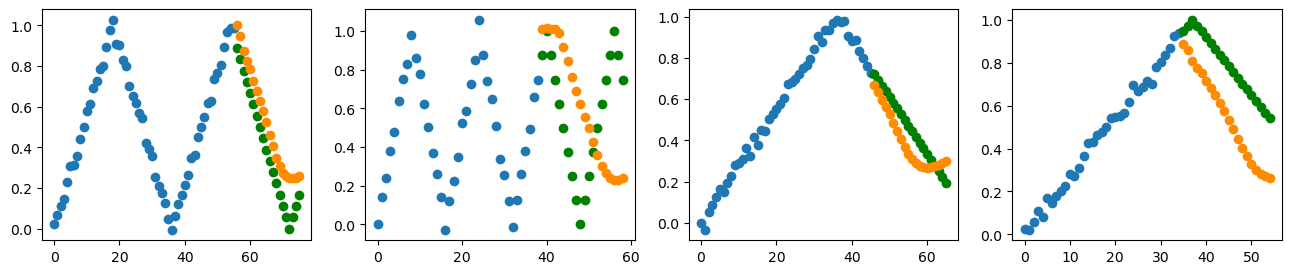

In [22]:
mean_loss, _ =evaluate(model, X_test, y_test, visualize_oneline=True)
print("MSE Loss: ", mean_loss)

Hier kann man grafisch definitiv eine Verbesserung zu den Dumb Baselines erkennen. Unser Model kann die aufgabe lösen, wir können das Ergebnis durch Hyperparameter Tuning oder Model Improvements (GRU, LSTM) jedoch wahrscheinlich verbessern.

# Looking for the best model 

Nachdem wir gezeigt haben, dass unser Model den Task bereits ansatzweise lösen kann, gilt es nun an den Hyperparametern zu drehen.

In diesem Abschnitt werden wir 1000 Datensätze verwenden (800 Train / 200 Test) und folgende Parameter versuchen zu optimieren:
- Optimizer (Adam / SGD)
- Hidden State Length (5 / 15 / 30 / 50 / 100)
- Model Architecture (Basic, GRU, LSTM) 

## Basic RNN

TrainingStats(train_loss=[0.28312647, 0.24340083, 0.23213258, 0.22372387, 0.21502554, 0.20157161, 0.20075734, 0.18761705, 0.17265381, 0.1641372, 0.15850149, 0.15245415, 0.14780556, 0.14245473, 0.14217778, 0.1358465, 0.13534814, 0.133956, 0.13566391, 0.1357707, 0.1469815, 0.12952341, 0.1269697, 0.13280763, 0.12465886, 0.12097584, 0.11839656, 0.119647875, 0.114585154, 0.11827802, 0.11711226, 0.11525622, 0.11652934, 0.11894366, 0.107973635, 0.110867105, 0.10819961, 0.11176823, 0.105428986, 0.11486904, 0.106220715, 0.10446747, 0.103398405, 0.10422962, 0.101327784, 0.10137601, 0.0958594, 0.099110104, 0.09706162, 0.094022706, 0.09353385, 0.09336456, 0.09474048, 0.089460656, 0.09031306, 0.08776768, 0.089963086, 0.08486952, 0.08468749, 0.08438631, 0.08263619, 0.08014589, 0.07731889, 0.08234778, 0.07681594, 0.078883566, 0.07470051, 0.1202653, 0.10341447, 0.08336809, 0.07340083, 0.06585049, 0.06722175, 0.06887337, 0.06374738, 0.067351885, 0.06460997, 0.064443484, 0.06286486, 0.06550133, 0.064094

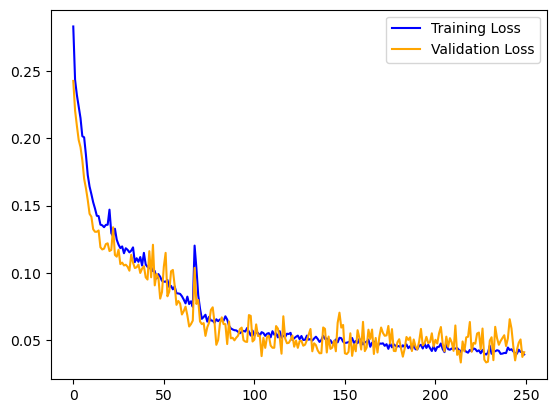

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data_set, labels, shuffle=True, random_state=RANDOM_SEED)

# Beginnen wir mit einem Basic RNN und 30 Hidden Length, mit 250 Epochen
basic_model = Base_RNN(1,30,1)
mse_loss = nn.MSELoss()
mae_loss = nn.L1Loss()
adam = torch.optim.Adam(basic_model.parameters(), lr=3e-4)
EPOCHS = 250

train(basic_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam)

(0.002894499, 0.001264601)

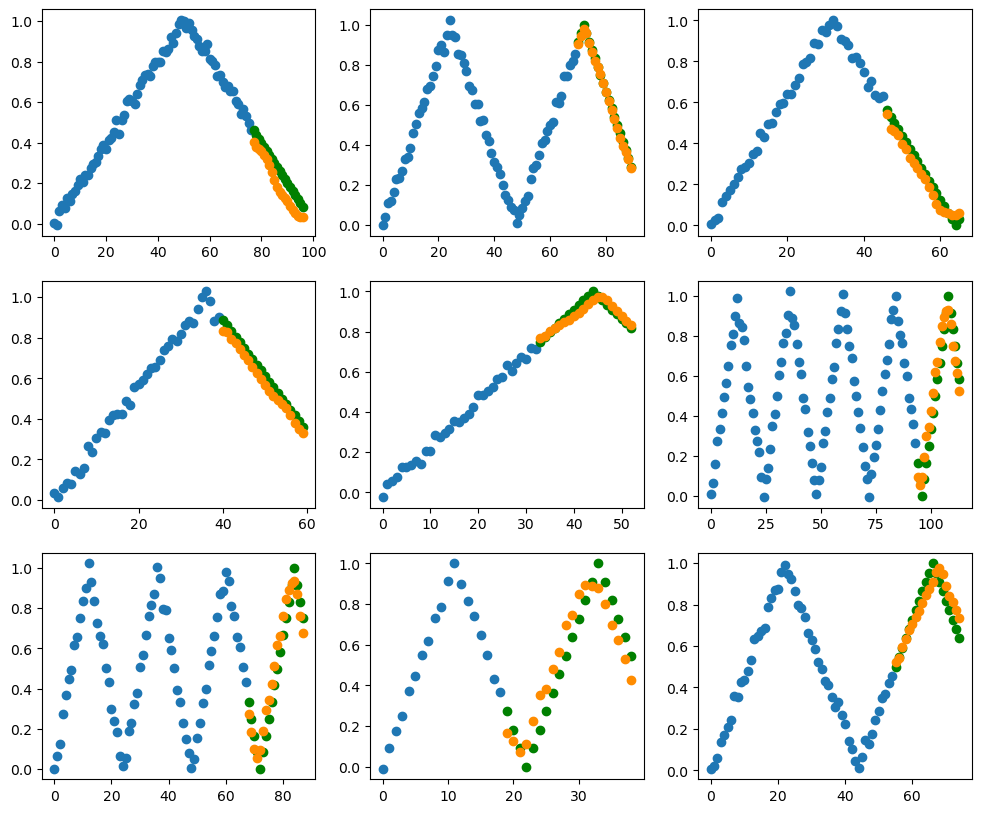

In [28]:
evaluate(basic_model, X_test, y_test, visualize_start_idx=30)
# torch.save(basic_model, "new_best_rnn.pt")
# torch.load("./best_models/new_best_rnn.pt") # best Base RNN - Trained with 250 epochs, Adam(lr=3e-4), MAE Loss 

## GRU Model

In [44]:
def move_to_mac_gpu(model: nn.Module) -> (nn.Module, torch.device):
    """If exists, move the model to Apple Neural Engine (sort of like cuda, but for apple devices)"""
    if torch.backends.mps.is_available():
        mps_device = torch.device("mps")
        print(type(mps_device))
        print(f"Moved {model.__class__.__name__} to MPS Device")
        return model.to(mps_device), mps_device
    else:
        print("MPS device not found.")
        return model, None


gru_model = GRU_RNN(1,30,1)
adam_gru = torch.optim.Adam(gru_model.parameters(), lr=3e-4)

train(gru_model, EPOCHS, X_train, y_train, loss_f=mae_loss, optimizer=adam_gru)

<class 'torch.device'>
Moved Base_RNN to MPS Device


AttributeError: 'list' object has no attribute 'to'

(0.004294692, 0.002443495)

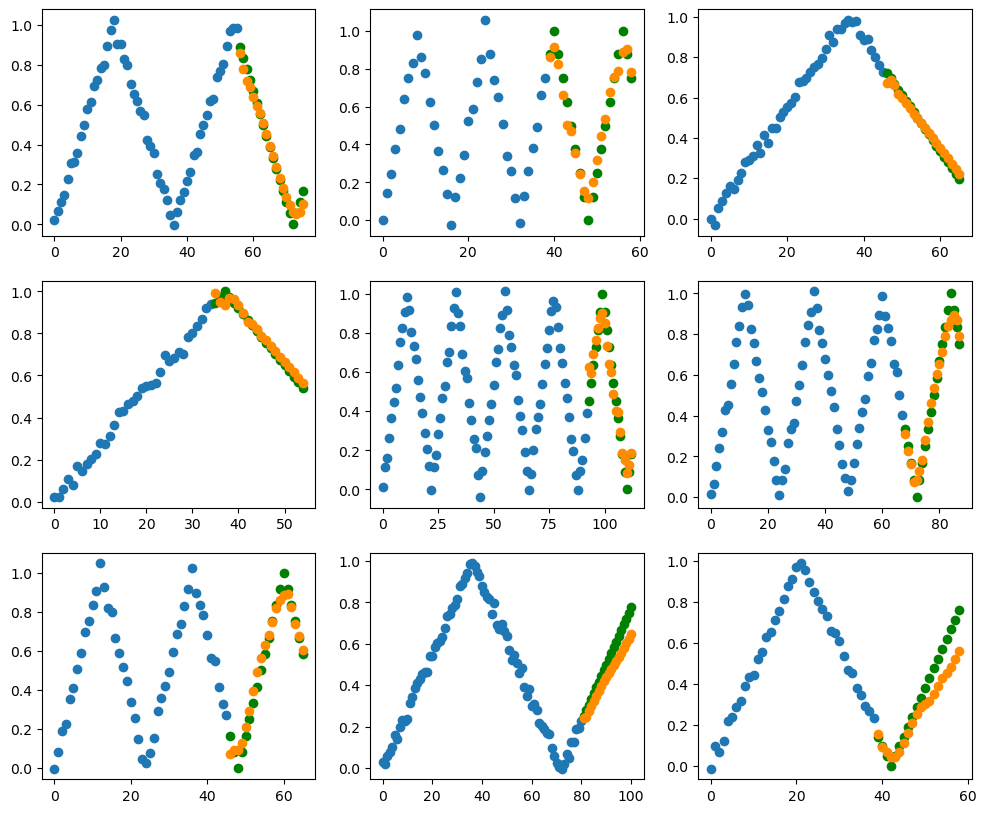

In [35]:
evaluate(gru_model, X_test, y_test)

Tomorrow, I want to test the following: